# Final Project Submission

- Student name:  Derek VanBriesen
- Student pace: full time
- Scheduled project review date/time: 
- Instructor name: Abhineet Kulkarni
- Blog post URL: http://dvbdatascience.blogspot.com/2020/06/movie-data-magic-reviewing-critics.html

# Module 1 Project
In order to help Microsoft better understand the movie industry, I have posed a few main questions that I would like to answer with the data.  
- Do critic reviews correlate with box office success?
- Do audience reviews correlate with box office success?
- Should MPAA rating be considered when trying to optimize profit?
    
By the end of the notebook we will be able to answer these questions, as well as provide actionable insights that can help make this movie venture a success.

In [2]:
#To start, we import the necessary data and packages.
import pandas as pd
import numpy as np
imdb_titles = pd.read_csv('module1_data/imdb.title.basics.csv')
imdb_ratings = pd.read_csv('module1_data/imdb.title.ratings.csv')
rt_reviews = pd.read_csv('module1_data/rt_reviews.tsv', delimiter='\t', encoding='latin1')
rt_info = pd.read_csv('module1_data/rt_movie_info.tsv', delimiter='\t')
tn_gross = pd.read_csv('module1_data/tn.movie.budgets.csv')

The first step will be to clean up the two datasets from Rotten Tomatoes.  These are rt_reviews and rt_info. These two datasets both contain an 'id' column, and the 'id' values in both datasets refer to the same movies. Since this is the case they can be linked using this ID, and we can use data from each one to perform analysis.  The columns of interest to us in rt_info are 'id', 'rating', theater_date', and 'box_office'

In [3]:
#First we will begin to clean the rt_info data.
#The box_office column of rt_info is full of NaN values, and the rest are strings.
#Dropping the NaN values won't hurt our calculations here
#Next, we convert the box_office strings to integers in a new column 'box_office_int'
rt_info = rt_info.dropna(subset=['box_office'])
box_office_int = []
for x in rt_info['box_office']:
    x = int(x.replace(',', ''))
    box_office_int.append(x)
rt_info['box_office_int'] = box_office_int

In [4]:
#Create new dataframe with only the relevant info from rt_info
info_cols = {'id': rt_info['id'],
             'rating': rt_info['rating'],
             'box_office_int': rt_info['box_office_int'],
             'theater_date': rt_info['theater_date']}
rt_combined = pd.DataFrame.from_dict(info_cols)
rt_combined.head()

,id,rating,box_office_int,theater_date
1,3,R,600000,"Aug 17, 2012"
6,10,PG-13,41032915,"Jan 11, 2002"
7,13,R,224114,"Apr 27, 2006"
8,14,R,134904,"Jun 30, 2010"
15,22,R,1039869,"Dec 17, 2010"


In [5]:
#Set the index to the 'id' column to prepare for concatenation
new_rt = rt_combined.set_index(rt_combined['id'])
new_rt.head()

,id,rating,box_office_int,theater_date
id,,,,
3,3,R,600000,"Aug 17, 2012"
10,10,PG-13,41032915,"Jan 11, 2002"
13,13,R,224114,"Apr 27, 2006"
14,14,R,134904,"Jun 30, 2010"
22,22,R,1039869,"Dec 17, 2010"


Next we have a bit of work to do with the rt_reviews dataset.  Here we are interested in the assiging a numeric rating to each unique 'id' value.  The 'fresh' column of rt_reviews contains a string denoting whether a critic approved or disapproved of a movie.  In order to make this a bit easier to work with, we will convert this to an integer (1 if fresh 0 if rotten) and create an integer column representing these fresh scores.

In [6]:
rt_reviews['fresh_int'] = ""
rt_reviews.loc[rt_reviews['fresh'] == 'fresh', 'fresh_int'] = 1
rt_reviews.loc[rt_reviews['fresh'] == 'rotten', 'fresh_int'] = 0
same_score_test = rt_reviews[rt_reviews['id'] == 10]
rt_reviews['score'] = ""


In [7]:
#Now we will count up how many reviews were given for each movie.
#We start by creating a dictionary that will contain each unique 'id' as each key
#And a corresponding number of reviews to complete each pair
unique_id = rt_reviews['id'].unique()
unique_dict = {}
for x in unique_id:
    unique_dict[x] = np.count_nonzero(rt_reviews['id'] == x)

In [8]:
#Next is to create a dataframe from that dictionary, empty column for the score
unique_df = pd.DataFrame.from_dict(unique_dict, orient='index', columns=['s_count'])
unique_df['score'] = ""

In [9]:
#Now we calculate the score for each movie by counting the number of positive fresh reviews
#And then dividing by the total score count to get a percent.  
for x,y in unique_dict.items(): 
    subset = rt_reviews[rt_reviews['id'] == x]
    score = subset['fresh_int'].sum() / y
    unique_df.loc[x, 'score'] = int(score*100)
unique_df.head()

,s_count,score
3,163,63
5,23,78
6,57,56
8,75,74
10,108,46


In [10]:
#Now concatenating the two Rotten Tomatoes frames into one
frames = [unique_df, new_rt]
new_frame = pd.concat(frames, axis = 1, join = 'inner')
new_frame = new_frame.drop(columns=['id'])
new_frame.head()

,s_count,score,rating,box_office_int,theater_date
3,163,63,R,600000,"Aug 17, 2012"
10,108,46,PG-13,41032915,"Jan 11, 2002"
13,95,64,R,224114,"Apr 27, 2006"
14,42,14,R,134904,"Jun 30, 2010"
23,233,91,R,99165609,"Dec 20, 2013"


In [11]:
#Creating a new column for 'year' since theater_date is a string
new_frame['year'] = ""
new_frame = new_frame.dropna(subset=['theater_date'])
new_frame = new_frame.reset_index()
new_frame = new_frame.rename(columns={'index':'id'})

new_frame.head()

,id,s_count,score,rating,box_office_int,theater_date,year
0,3,163,63,R,600000,"Aug 17, 2012",
1,10,108,46,PG-13,41032915,"Jan 11, 2002",
2,13,95,64,R,224114,"Apr 27, 2006",
3,14,42,14,R,134904,"Jun 30, 2010",
4,23,233,91,R,99165609,"Dec 20, 2013",


In [12]:
#Using a for loop to fill in the year for each movie
for x in new_frame.index:
    year = int(new_frame.iloc[x,5][-4:])
    new_frame.iloc[x,6] = year
new_frame.head()
#This data is now ready to be analyzed 

,id,s_count,score,rating,box_office_int,theater_date,year
0,3,163,63,R,600000,"Aug 17, 2012",2012
1,10,108,46,PG-13,41032915,"Jan 11, 2002",2002
2,13,95,64,R,224114,"Apr 27, 2006",2006
3,14,42,14,R,134904,"Jun 30, 2010",2010
4,23,233,91,R,99165609,"Dec 20, 2013",2013


In [13]:
#creating a new frame without the 'theater_date' column
#also dropping rows with NaN values in the ratings column
#and creating a list of unique ratings
new_frame2 = new_frame.drop(columns=['theater_date'])
new_frame2 = new_frame2.dropna(subset=['rating'])
new_frame2 = new_frame2.fillna(0)
rating_list2 = sorted(new_frame2['rating'].unique())
print(rating_list2)

['G', 'NR', 'PG', 'PG-13', 'R']


In [14]:
#using the list of ratings, create a list of the box office sum for each rating
sum_list2 = []
for rate in rating_list2:
    rate_sum = new_frame2[new_frame2['rating'] == rate]
    sum_list2.append(rate_sum['box_office_int'].sum())
print(sum_list2)
#rating_list2 and sum_list2 are now ready to be analyzed

[159920588, 7785558, 2268891785, 5995270396, 3218503413]


# IMDB Datasets
The next step will be cleaning the two IMDB datasets imdb_ratings and imdb_titles.  Similar to the RT data, these have a unique movie id in the 'tconst' column.  This refers to the same movie in each set, so the data can be concatenated and analyzed.  Eventually we will be combining this with the tn_budget dataset.

In [15]:
#Reindexing the two IMDB datasets so that they can be combined
redexed_ratings = imdb_ratings.dropna().set_index('tconst')
redexed_titles = imdb_titles.dropna().set_index('tconst')

In [16]:
combo = [redexed_titles, redexed_ratings]
imdb_combined = pd.concat(combo, axis = 1, join = 'inner')
imdb_combined.head()

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263


In [17]:
#Cleaning the combined data.  Dropping unneeded columns, dropping duplicates,
#and setting the index to be the movie name
#Also removing certain symbols from movie names to increase chance of match
#(Data is from different sites with different style guidelines)

imdb_test = imdb_combined.rename(columns={'primary_title': 'movie'})
imdb_test[imdb_test.columns[0]] = imdb_test[imdb_test.columns[0]].replace('[\$,:.!-]', '', regex=True)
imdb_test = imdb_test.drop_duplicates(subset=['movie'])
imdb_test = imdb_test.reset_index(drop=True)
imdb_test = imdb_test.set_index('movie')
imdb_test = imdb_test.drop(columns=['original_title'])
imdb_test.head()
#This is now ready to be combined with tn_budget

,start_year,runtime_minutes,genres,averagerating,numvotes
movie,,,,,
Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43
The Other Side of the Wind,2018,122.0,Drama,6.9,4517
The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263


# tn_gross Dataset
On to the last dataset, tn_gross.  This will be combined with the IMDB data by matching movie names.  We will also be creating a 'profit' column so we can examine that number as well.

In [18]:
#We begin by cleaning tn_gross by dropping NaN values and resetting the index
new_tn = tn_gross.dropna()
new_tn.reset_index(drop=True)
new_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [19]:
#Changing the strings in the budget and gross columns to floats so profit can be calculated
new_tn[new_tn.columns[3:]] = new_tn[new_tn.columns[3:]].replace('[\$,]', '', regex=True).astype(float)
new_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [20]:
#Calculating the profit for each movie
#Also creating a 'year' column since the 'release_date' is stored as a string
new_tn['profit'] = new_tn['worldwide_gross'] - new_tn['production_budget']
new_tn['year'] = ""
new_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,year
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,


In [21]:
#Filling in the year column by looping over the 'release_date' strings
for x in new_tn.index:
    year = int(new_tn.iloc[x,1][-4:])
    new_tn.iloc[x,7] = year
new_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,year
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,2017


In [22]:
#Creating a new dataframe that doesn't contain irrelevant columns
#Removing the same symbols from the movie names as we did with the IMDB data
tn_profit = new_tn.drop(columns=['release_date', 'id'])
tn_profit[tn_profit.columns[0]] = tn_profit[tn_profit.columns[0]].replace('[\$,:.!-]', '', regex=True)
tn_profit.head()

,movie,production_budget,domestic_gross,worldwide_gross,profit,year
0,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,2009
1,Pirates of the Caribbean On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2011
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,2019
3,Avengers Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,2015
4,Star Wars Ep VIII The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,2017


In [23]:
#Dropping duplicate movies and resetting the index to the movie column
testframe = tn_profit.drop_duplicates(subset=['movie'])
testframe = testframe.reset_index(drop=True)
testframe = testframe.set_index('movie')
testframe.head()
#This data is now ready for concatenation

,production_budget,domestic_gross,worldwide_gross,profit,year
movie,,,,,
Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,2009
Pirates of the Caribbean On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,2011
Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,2019
Avengers Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,2015
Star Wars Ep VIII The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,2017


In [24]:
#Concatenating the two tables here
test_group = [imdb_test, testframe]
imdb_profit = pd.concat(test_group, axis = 1, join = 'inner')
imdb_profit.head()
#This data is now ready to be analyzed

,start_year,runtime_minutes,genres,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,profit,year
movie,,,,,,,,,,
Foodfight,2012,91.0,"Action,Animation,Comedy",1.9,8248,45000000.0,0.0,7.370600e+04,-4.492629e+07,2012
On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,25000000.0,720828.0,9.313302e+06,-1.568670e+07,2013
The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,91000000.0,58236838.0,1.878612e+08,9.686118e+07,2013
A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,28000000.0,26017685.0,6.210859e+07,3.410859e+07,2014
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,215000000.0,652270625.0,1.648855e+09,1.433855e+09,2015


In [25]:
#I would also like to examine the top ten percent of highest grossing movies
#Here I will find the 90th percentile value, and subset the dataframe accordingly
gross_percent = imdb_profit['worldwide_gross'].quantile(.9)
gross_subset = imdb_profit[imdb_profit['worldwide_gross'] >= gross_percent]
gross_subset.head()

,start_year,runtime_minutes,genres,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,profit,year
movie,,,,,,,,,,
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,215000000.0,652270625.0,1.648855e+09,1.433855e+09,2015
Tangled,2010,100.0,"Adventure,Animation,Comedy",7.8,366366,260000000.0,200821936.0,5.864772e+08,3.264772e+08,2010
Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218,200000000.0,415004880.0,1.068880e+09,8.688795e+08,2010
Alita Battle Angel,2019,122.0,"Action,Adventure,Sci-Fi",7.5,88207,170000000.0,85710210.0,4.029760e+08,2.329760e+08,2019
Shazam,2019,132.0,"Action,Adventure,Comedy",7.4,109051,85000000.0,139606856.0,3.628997e+08,2.778997e+08,2019


In [26]:
#I would also like to examine the top ten percent of highest profit movies
#Here I will find the 90th percentile value, and subset the dataframe accordingly
profit_percent = imdb_profit['profit'].quantile(.9)
profit_subset = imdb_profit[imdb_profit['profit'] >= profit_percent]
profit_subset.head()

,start_year,runtime_minutes,genres,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,profit,year
movie,,,,,,,,,,
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,215000000.0,652270625.0,1.648855e+09,1.433855e+09,2015
Tangled,2010,100.0,"Adventure,Animation,Comedy",7.8,366366,260000000.0,200821936.0,5.864772e+08,3.264772e+08,2010
Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218,200000000.0,415004880.0,1.068880e+09,8.688795e+08,2010
Alita Battle Angel,2019,122.0,"Action,Adventure,Sci-Fi",7.5,88207,170000000.0,85710210.0,4.029760e+08,2.329760e+08,2019
Shazam,2019,132.0,"Action,Adventure,Comedy",7.4,109051,85000000.0,139606856.0,3.628997e+08,2.778997e+08,2019


In [27]:
#Calculating all of the relevant correlation coefficients
#Also creating a list of the ones dealing with gross box office 
critic_coef = np.corrcoef(new_frame['score'], new_frame['box_office_int'])
gross_coef = np.corrcoef(imdb_profit['averagerating'], imdb_profit['worldwide_gross'])
profit_coef = np.corrcoef(imdb_profit['averagerating'], imdb_profit['profit'])
gross_coef_10th = np.corrcoef(gross_subset['averagerating'], gross_subset['worldwide_gross'])
profit_coef_10th = np.corrcoef(profit_subset['averagerating'], profit_subset['profit'])
coef_list = [critic_coef[0,1], gross_coef[0,1], gross_coef_10th[0,1]]
label_list = ['Critics', 'Audience', 'Top 10%']
print(coef_list)

[[1.         0.22237258]
 [0.22237258 1.        ]]


# A Few Quick Notes on Significance Testing
- The variable coef_list contains the Pearson coefficients. 
- P-values are pulled from an online calculator and will be listed in the next cell
- Significance testing is done at the 95% confidence interval
- Null hypothesis in this case is that the coefficient = 0 
- Degrees of freedom for each sample are listed below as well for reference

In [28]:
#Quickly comparing each correlation coefficient to the corresponding p_value
deg_of_freedom = [len(new_frame)-1, len(imdb_profit)-1, len(gross_subset)-1]
p_values = [.31, .00001, .005]
sig_test = np.array(coef_list) > np.array(p_values)
print(sig_test)
#The test tells us that both of the audience correlations were significant
#It also tells us that the critic score was not significant.

[False  True  True]


In [29]:
#The final step will be plotting all of the data we have gathered.
#The below command can be toggled to export graphs when they are shown 
#Set it to 'True' in order to export
export_check = False

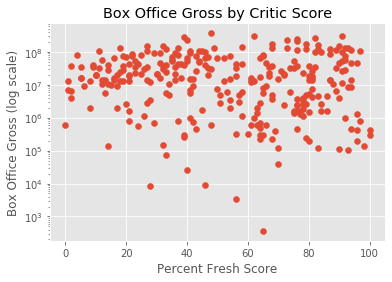

In [213]:
#Here we begin plotting the data we prepared earlier
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.scatter(new_frame['score'], new_frame['box_office_int'])
plt.yscale('log')
plt.xlabel("Percent Fresh Score")
plt.ylabel("Box Office Gross (log scale)")
plt.title("Box Office Gross by Critic Score")
if export_check:
    plt.savefig("critic_score.png", dpi=300)
plt.show()

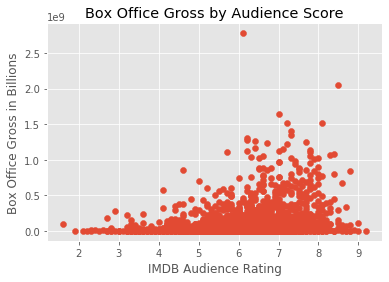

In [214]:
#Plotting the audience rating and gross for all movies
plt.scatter(imdb_profit['averagerating'], imdb_profit['worldwide_gross'])
plt.xlabel("IMDB Audience Rating")
plt.ylabel("Box Office Gross in Billions")
plt.title("Box Office Gross by Audience Score")
if export_check:
    plt.savefig("gross_audience.png", dpi=300)
plt.show()

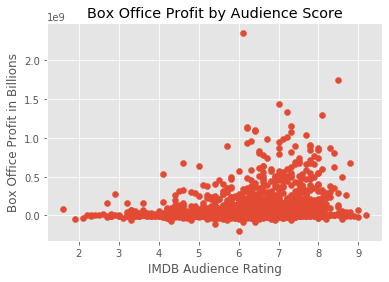

In [215]:
#Plotting the audience rating and profit for all movies
plt.scatter(imdb_profit['averagerating'], imdb_profit['profit'])
plt.xlabel("IMDB Audience Rating")
plt.ylabel("Box Office Profit in Billions")
plt.title("Box Office Profit by Audience Score")
if export_check:
    plt.savefig("profit_audience.png", dpi=300)
plt.show()

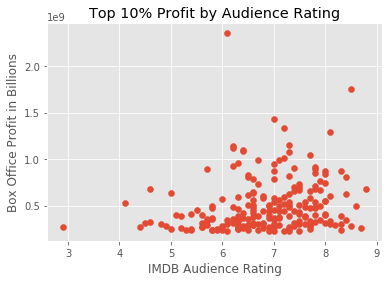

In [216]:
#Plotting the profit of the top ten percent highest profit movies
plt.scatter(profit_subset['averagerating'], profit_subset['profit'])
plt.xlabel("IMDB Audience Rating")
plt.ylabel("Box Office Profit in Billions")
plt.title("Top 10% Profit by Audience Rating")
if export_check:
    plt.savefig("profit_audience_10.png", dpi=300)
plt.show()

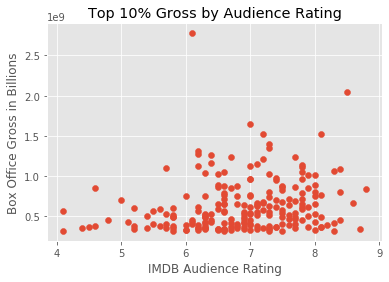

In [217]:
#Plotting the gross of the top ten percent highest grossing movies
plt.scatter(gross_subset['averagerating'], gross_subset['worldwide_gross'])
plt.xlabel("IMDB Audience Rating")
plt.ylabel("Box Office Gross in Billions")
plt.title("Top 10% Gross by Audience Rating")
if export_check:
    plt.savefig("gross_audience_10.png", dpi=300)
plt.show()

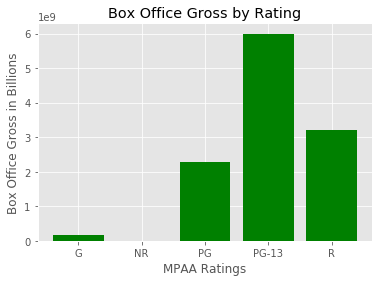

In [218]:
#Plotting the total box office gross for each rating (for the rt dataset) 
plt.style.use('ggplot')
fig, ax = plt.subplots()
plt.bar(rating_list2, sum_list2, color='green')
plt.xlabel("MPAA Ratings")
plt.ylabel("Box Office Gross in Billions")
plt.title("Box Office Gross by Rating")
if export_check:
    plt.savefig("rating_gross.png", dpi=300)
plt.show()

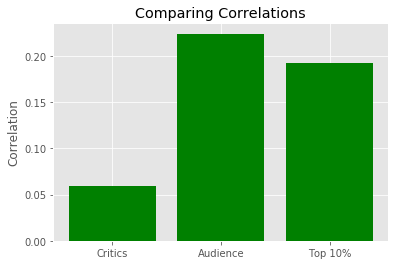

In [219]:
#Plotting a comparison between critic and audience correlation
plt.style.use('ggplot')
fig, ax = plt.subplots()
plt.bar(label_list, coef_list, color='green')
plt.ylabel("Correlation")
plt.title("Comparing Correlations")
if export_check:
    plt.savefig("compare_corr.png", dpi=300)
plt.show()

# Conclusions

Throughout this notebook we have examined the data in order to address the three questions posed earlier. 

- Critic reviews **do not** have a significant correlation with box office success.
- Audience reviews **do** have a significant correlation with box office success, and it is much stronger than critic reviews. 
- PG-13 movies tend to be the most successful at the box office.
    
With these answers, we are able to provide some actionable insight to Microsoft.  First, we would not recommend simply following whatever trends are critically successful at the time, since there is little reason to believe that this will lead to future box office success.  With audiences though we do see a statistically significant correlation between reviews and box office success.  Our recommendation here would be to engage in extensive focus testing in order to gauge audience reactions.  Finally, based on the data we would recommend creating a PG-13 movie, since those garner a much larger share of the total box office gross.  